# Projet Python Machine Learning
## Mastère Spécialisé Data Science
### Machraoui Ismail - David Duong Prunier


Détection de Buzz dans le réseau social Twitter
==========================

### Introduction
    
Twitter est un réseau social permettant le partage d'information sous forme de tweet qui sont des messages courts. La particularité de twitter est de pouvoir attacher à ce message des mots-clés (hashtag), qui peuvent alors être repris par d'autres utilisateurs, ou de pouvoir reprendre un message et le diffuser sur son propre compte, on parle alors de retweet. Avec la croissance du nombre d'utilisateurs, nous pouvons constater que certain messages et/ou information peuvent avoir un écho fort avec un impact sociétale. On parle alors de Buzz. 

Cette étude à pour objectif de déterminer si un sujet en particulier, peut être considérer comme faisant Buzz ou non. Nous ferons cette étude sur une base de données de tweeter disponible sur le site de l'UCI(1). Ces données représentent 143000 tweets avec des indicateurs d'évolution sur certains critèes comme le nombre de discussions crées,le niveau d'attention, le nombre d'auteurs par mot clé, nombre de nouveaux sujets ...
    
    
### Préliminaires
    
#### Cadre général
    
La notion de Buzz est mal définie dans la littérature et n'a pas de définition mathématique précise. On acceptera dans ce document que le Buzz représente l'acroissement rapide d'activité (Tweets, Retweets) sur une période courte. Cette croissance peut être matéliarisée comme un pic, c'est le cas par exemple d'un évènement exceptionnel (un but de foot, un tremblement de terre), ou matéliarisée comme une croissance régulière (un groupe de musique exceptionnel, vidéo de chat…). Nous porterons donc notre attention sur la détermination de ces deux types d'évènement porté sur une  d'observation de 7 périodes avec un espacement temporelle non déterminée.  
    
#### Description des données
    
Les données sont extraites de la base de données de l'UCI qui ont servi de base pour l'étude menée par F. Kawala, A. Douzal-Chouakria, E. Gaussier, E. Dimert afin de prédire l'effet de Buzz dans les résaux *Twitter* et *Tom's Hardware*. Nous allons nous concentrer sur le résau social Twitter qui est composé de 143000 tweets et 77 features, représentant en réalité que 11 features mesurées en 7 temps différents (7x11 = 77).
   

### Visualisation des données
    
#### Extraction des données
Le code suivant permet d'extraire les données du fichier CSV et de les matérialiser dans un dataframe.

In [22]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from numpy import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import KFold
from sklearn import neighbors
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import zero_one_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cm
import timeit
from sklearn import svm
from sklearn.metrics import hinge_loss
from sklearn.linear_model import SGDClassifier
import copy
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc
from IPython.core.display import Image
from sklearn.cross_validation import train_test_split

%matplotlib inline

pathToDataset = "Twitter-Absolute-Sigma-500.csv"
data = pandas.read_csv(pathToDataset, sep=",",encoding="utf8")
data.head(10)

,NCD_0,NCD_1,NCD_2,NCD_3,NCD_4,NCD_5,NCD_6,AI_0,AI_1,AI_2,...,ADL_5,ADL_6,NAD_0,NAD_1,NAD_2,NAD_3,NAD_4,NAD_5,NAD_6,Annotation
0,889,939,960,805,805,1143,1121,549,613,587,...,1,1.000000,889,939,960,805,805,1143,1121,1
1,542,473,504,626,647,795,832,366,288,318,...,1,1.000000,542,473,504,626,647,795,832,1
2,92,99,196,100,184,79,162,66,59,118,...,1,1.000000,92,99,196,100,184,79,162,0
3,90,87,92,344,184,848,184,83,78,76,...,1,1.000000,90,87,92,344,184,848,184,1
4,169,98,101,90,96,95,185,141,68,85,...,1,1.000000,169,98,101,90,96,95,185,1
5,775,765,935,806,912,1095,1198,614,588,751,...,1,1.000000,775,765,935,806,912,1095,1198,1
6,469,1092,332,354,357,676,1189,348,909,261,...,1,1.000000,469,1092,332,354,357,676,1189,1
7,818,693,756,1099,877,871,1409,578,516,546,...,1,1.000000,818,693,756,1099,877,871,1409,1
8,832,628,898,944,993,983,1037,543,432,627,...,1,1.000000,832,628,898,944,993,983,1037,1
9,920,1071,833,662,851,1096,1067,659,790,601,...,1,1.013109,920,1071,833,662,851,1096,1068,1


#### Description des variables
    
+ NCD : Number of created discussions
+ AI : Author increase
+ AS(NA) : Attention Level (measured with number of authors)
+ AS(NAC) : Attention Level (measured with number of contributions)
+ BL : Burstiness level
+ NAC : Number of Atomic Containers
+ CS : Contribution Sparseness 
+ AT : Author iteration
+ NA :  Number of Authors
+ ADL : Average Discussions Length
+ NAD : Average Discussions Length

Parmis ces variables 3 sont des indicateurs relatifs aux auteurs tandis que le reste, 8 variables donc, sont relatifs aux discussions. Dans l'étude qui suit, nous n'allons pas ségréger les variables d'auteurs et variables de discussions. L'intuition nous permet de dire que ces deux catégories de variales peuvent être liées. (Faire auto correlation ? Granger ? VAR) 

#### Transformation des données, normalisation et manipulation des tables

In [2]:
#normalisation de donnee par la moyenne
df_nonNormalized = data.iloc[:, :77]
print(df_nonNormalized.shape)
y = data.iloc[:,77]

cccolumn = df_nonNormalized
#cccolumn[cccolumn==0] = 1
stdColumns = cccolumn.std()
#stdColumns[stdColumns == 0] = 1
df_Normalized =(df_nonNormalized - df_nonNormalized.mean()) / stdColumns

(140707, 77)


##### Quelques exemples et observations

In [3]:
def plotBuzz(originalData,n,withbuzz,withoutbuzz):
    
    notBuzzSample = random.random_integers(0,np.size(y[y==0]),n)
    buzzSample = random.random_integers(0,np.size(y[y==1]),n)
    notbuzzindex = np.where(y==0)[0][notBuzzSample]
    buzzindex = np.where(y==1)[0][buzzSample]
    
    
    varsToDisplay= np.arange(0,77,7)
    variableNames = originalData.iloc[:,varsToDisplay].columns
    variableNames = list(map(lambda x : x.split("_")[0],variableNames))
    
    buzz = originalData.iloc[buzzindex,:]
    notbuzz = originalData.iloc[notbuzzindex,:]
    
    x= np.arange(0,7)
    gs = gridspec.GridSpec(6, 2)
    
    for i in range(0,7) : 
            fig = plt.figure(num=1, figsize=(18, 20), dpi=100, facecolor='w', edgecolor='k')
            ax = fig.add_subplot(gs[i])
            if withbuzz == 1 :
                ax.plot(x,buzz.iloc[:,i:i+7].transpose(),'-o', label = 'buzz')
            if withoutbuzz == 1 : 
                ax.plot(x,notbuzz.iloc[:,i:i+7].transpose(),'-^', label = 'no buzz')
            plt.xlabel('t', fontsize=18)
            ax.xaxis.set_label_coords(1.02, -0.025)
            plt.title(variableNames[i], fontsize=20)
            ax.legend(loc='best')

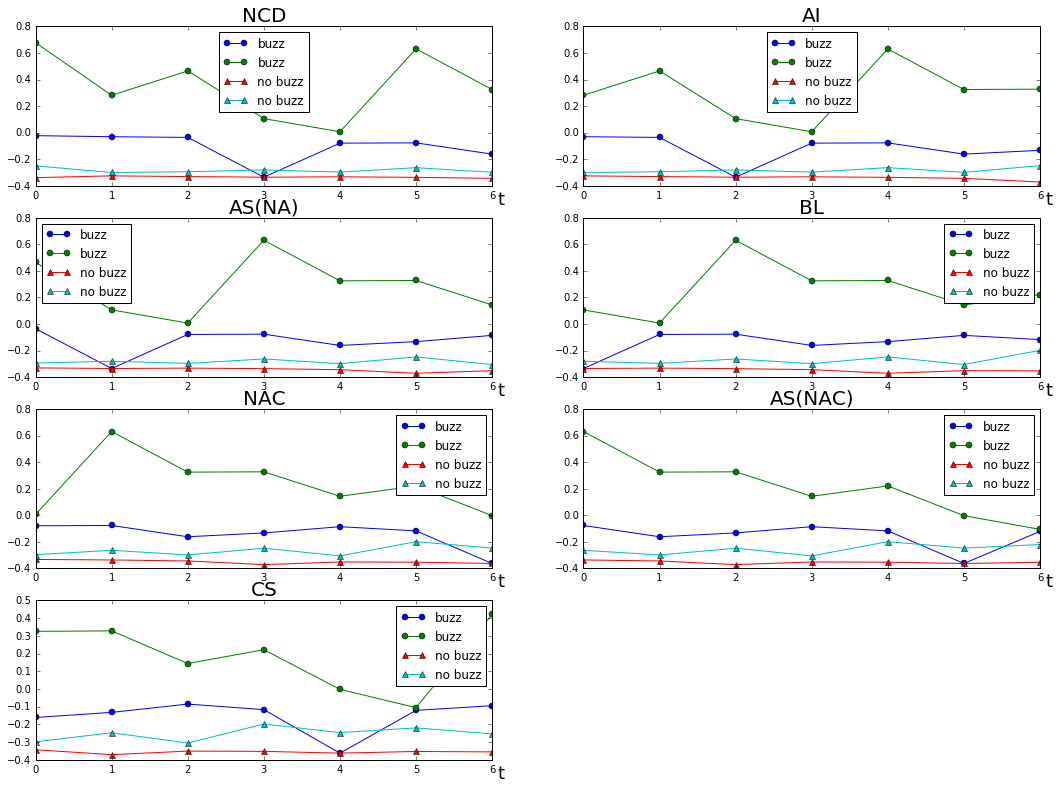

In [4]:
plotBuzz(df_Normalized,2,1,1)

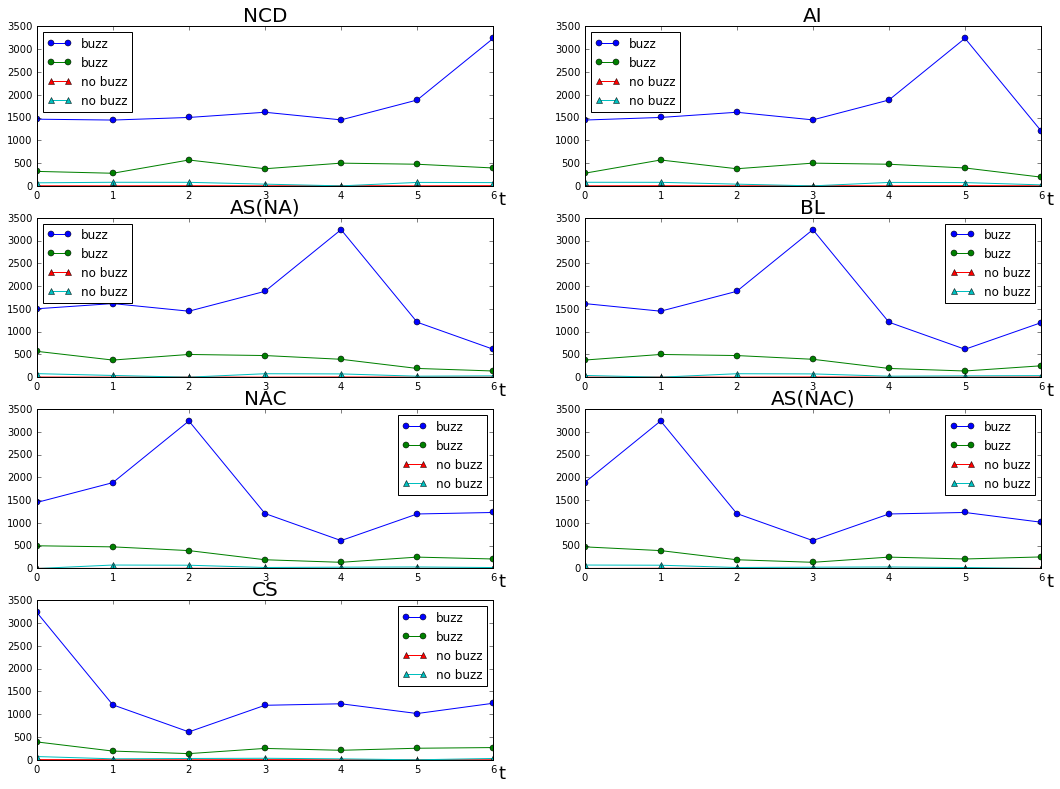

In [5]:
plotBuzz(df_nonNormalized,2,1,1)

L'observation nous permet de dégager une première intuition. L'état de Buzz est soit une fonction croissante des variables AS, NA, NAC,AS(NAC). Ou un Buzz peut être caracterisé par la croissance soudaine d'une ou plusieurs variables.
En ce sens nous considérerons les **accroissements** entre la période T0 et la valeur **MAX** atteinte entre T1 et T6.


#### Observations

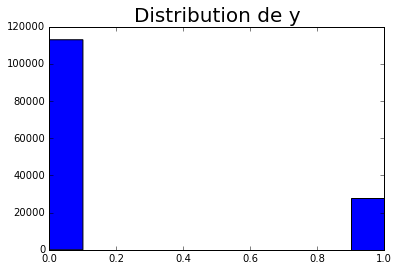

In [6]:
plt.hist(y)
plt.title("Distribution de y", fontsize=20)

Nous observons que la distribution n'est pas toute à fait équilibrée. En effet le nombre de sujet qui ne Buzz pas excède de loin les sujets qui Buzz. Le rapport est de l'ordre de 21%. Dans le cas extrême où un algorithme soit totalement nul et qui affecte 0 systématiquement, on pourrait croire que la performance de cet algorithme est bon, car la prédiction sera bonne de 80% alors qu'en réalité il n'est pas bon du tout. <br/><br/>
Dans la suite de ce projet, nous allons sytématiquement regarder la matrice de confusion et relater les résultats à l'observation ci-dessus dans une première approche.Dans une seconde approche, nous allons biaiser les datas de sorte que les observations y=0 et y=1 soient de même taille.

In [7]:
notBuzzSample = random.random_integers(0,np.size(y[y==0]),np.size(y[y==1]))
notbuzz = np.where(y==0)[0][notBuzzSample]
buzz = np.where(y==1)[0]
X_unif = pandas.concat([df_nonNormalized.iloc[notbuzz,:],df_nonNormalized.iloc[buzz,:]],axis=0)
y_unif = pandas.concat([y.iloc[notbuzz],y.iloc[buzz]],axis=0)

In [8]:
print("X_unif",X_unif.shape)
print("y_unif",y_unif.shape)

X_unif (55550, 77)
y_unif (55550,)


*** Premiers indices de chaque variable ***

In [9]:
t = []
for i in range(0,76) : 
    ind = i %7
    if(ind == 0):
        t.append(i)

t = np.asarray(t)

# Application de différentes méthodes de classification
----------------------

Préliminaire : Identifications des variables significatives
-------------------------


**Random Forest**

On utilise le random forest sur toutes les variables à un seul instant (t=0) pour essayer de voir s'il y en a certaines qui se démarquent, en utilisant les importances de chacunes.

*** Random forest sur une sélection de variables ***

(-1, 77)

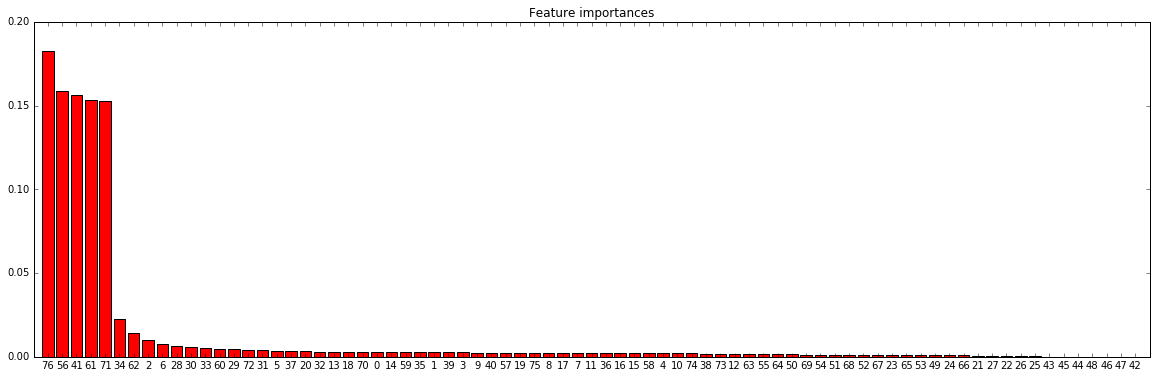

In [10]:
forest = RandomForestClassifier(n_estimators=5,random_state=1234)

forest.fit(X_unif, y_unif)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(df_nonNormalized.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(df_nonNormalized.shape[1]), indices)
plt.xlim([-1, df_nonNormalized.shape[1]])

*** Random forest sur toutes les variables ***

([<matplotlib.axis.XTick at 0x13d37a58>,
 <a list of 9 Text xticklabel objects>)

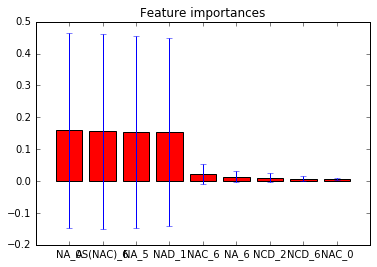

In [11]:
plt.title("Feature importances")
plt.bar(range(1,10), importances[indices][1:10],
       color="r", yerr=std[indices[1:10]], align="center")
plt.xticks(range(1,10), df_nonNormalized[indices[1:10]].columns)


**Selection de features avec SelectModel**

In [12]:
# threshold chosen is the mean (by default) (equivalent to importances[importances>np.mean(importances)])
model = SelectFromModel(forest, prefit=True)
X_new = model.transform(X_unif)

In [13]:
test = pandas.DataFrame(X_new)
importantVariableIndexes = model.get_support(range(0,77))
selectedVariables = X_unif.columns[importantVariableIndexes]

print("Les variables sélectionnées pour l'étude :",selectedVariables.tolist())

Les variables sélectionnées pour l'étude : ['NAC_6', 'AS(NAC)_6', 'NA_0', 'NA_5', 'NA_6', 'NAD_1', 'NAD_6']


**Agrégation de variables (features supplémentaires)**

In [14]:
indices_variables_auteurs = [7,49,56]
#Ajout de nouvelles variables (colonnes) de l'accroissement entre t=0 et max[t=0:t=6] pour chacun des types des variables.

accroissements = pandas.DataFrame({})
for i in t :
    maxes = df_nonNormalized.iloc[:,i:i+7].max(1)
    column = df_nonNormalized.iloc[:,i]
    # Pour les variables qui commencent a 0, eviter de diviser par 0
    column[column==0] = 1
    accroissements[i] = (maxes - df_nonNormalized.iloc[:,i])/column
accroissements.columns = df_nonNormalized.iloc[:,t].columns + "_increase"
#df_nonNormalized = pandas.concat([df_nonNormalized,accroissements],axis =1)


D:\PyEnsae\python\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Méthode 1 : K-NN neighbours classifier
--------------------------

In [15]:
#Cross-validation testing (using 5 folds)
def knnClassifier(data,y,n_jobs):
    predicted = pandas.DataFrame({})
    scores = np.zeros((10,5))
    f1scores = np.zeros((10,5))
    for n_neighbors in range(1,11):
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform",metric="manhattan",p=2,n_jobs=n_jobs)
        predicted[n_neighbors -1] = cross_val_predict(clf, data,y, cv=5)
        scores[n_neighbors - 1] = 1 - zero_one_loss(y,predicted[n_neighbors-1],normalize=True)
        f1scores[n_neighbors - 1] = f1_score(y,predicted[n_neighbors -1])
    mean_scores = scores.mean(1)
    mean_f1scores = f1scores.mean(1)
    kmax = mean_scores.argmax() 
    print("K choisi : ",kmax," pour le score (0/1 loss) : ", mean_scores[kmax -1])
    print("K choisi : ",kmax," pour le score (F1 score) : ", mean_f1scores[kmax -1])
    print("La matrice de confusion pour le meilleur k :\n",cm(y,predicted[kmax]))
    

In [16]:
#Classifier avec toutes les variables d'accroissements 
start_time = timeit.default_timer()
knnClassifier(accroissements,y,-1)
elapsed = timeit.default_timer() - start_time
print(elapsed,"seconds")

K choisi :  9  pour le score (0/1 loss) :  0.80364160987
K choisi :  9  pour le score (F1 score) :  0.37594018928
La matrice de confusion pour le meilleur k :
 [[107483   5449]
 [ 21419   6356]]
242.43072296517283 seconds


La performance du KNN est très médiocre. Le nombre de valeur mal prédite pour les sujets qui Buzz sont de 21422 soit 77% !! Donc seulement 23% de Buzz correctement prédits. 



In [17]:
#Classifier qu'avec les variables d'accroissement d'auteurs :
knnClassifier(accroissements.iloc[:,np.divide(indices_variables_auteurs,7)],y,-1)

K choisi :  9  pour le score (0/1 loss) :  0.794494943393
K choisi :  9  pour le score (F1 score) :  0.275723875363
La matrice de confusion pour le meilleur k :
 [[108881   4051]
 [ 24000   3775]]


In [18]:
#Classifier qu'avec les variables liées aux discussions 
indices_contributions_variables = np.setdiff1d(np.arange(0,11),np.divide(indices_variables_auteurs,7))
knnClassifier(accroissements.iloc[:,indices_contributions_variables],y,-1)

K choisi :  9  pour le score (0/1 loss) :  0.805141179899
K choisi :  9  pour le score (F1 score) :  0.350007112038
La matrice de confusion pour le meilleur k :
 [[108210   4722]
 [ 22270   5505]]


In [19]:
knnClassifier(X_unif,y_unif,-1)

K choisi :  6  pour le score (0/1 loss) :  0.950711071107
K choisi :  6  pour le score (F1 score) :  0.950132954504
La matrice de confusion pour le meilleur k :
 [[26501  1274]
 [ 1328 26447]]


In [20]:
knnClassifier(X_unif.iloc[:,importantVariableIndexes],y_unif,-1)


K choisi :  8  pour le score (0/1 loss) :  0.95099909991
K choisi :  8  pour le score (F1 score) :  0.950656225074
La matrice de confusion pour le meilleur k :
 [[26419  1356]
 [ 1295 26480]]


Méthode 2 : Decision Tree Classifier
--------------------------

max_depth 1 erreur 0.426232915823 0.429482660871
max_depth 2 erreur 0.365645753007 0.366349559612
max_depth 3 erreur 0.365645753007 0.366349559612
max_depth 4 erreur 0.365645753007 0.366349559612
max_depth 5 erreur 0.364323393443 0.364197578181
max_depth 6 erreur 0.357934737656 0.360124217035
max_depth 7 erreur 0.356940575619 0.360034503714
max_depth 8 erreur 0.354480378168 0.35934595749
max_depth 9 erreur 0.351761826572 0.359136137919


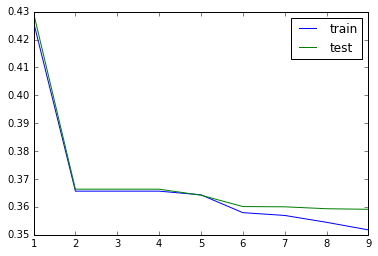

In [26]:
#sur les variables d'accroissements
a_train, a_test, b_train, b_test = train_test_split(accroissements, y, test_size=0.33)


curves = []
for max_depth in range(1,10) :
    clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=max_depth)
    clf = clf.fit(a_train, b_train)
    erra = mean_squared_error( clf.predict(a_train), b_train)**0.5
    errb = mean_squared_error( clf.predict(a_test), b_test)**0.5
    print("max_depth",max_depth, "erreur",erra,errb)
    curves.append((max_depth, erra,errb, clf) )
plt.plot ( [c[0] for c in curves], [c[1] for c in curves], label="train")
plt.plot ( [c[0] for c in curves], [c[2] for c in curves], label="test")
plt.legend()


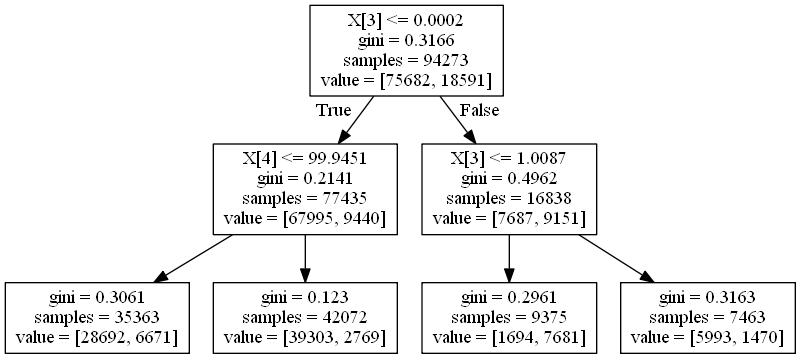

In [27]:
clf1 = DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
clf1 = clf1.fit(a_train, b_train)


export_graphviz(clf1, out_file="arbre1.dot")
# on remplace X[i] par les noms des variables
with open("arbre1.dot","r") as f: text = f.read()

with open("arbre1.dot","w") as f: f.write(text)
cwd = os.getcwd()
os.system ("\"D:\\PyEnsae\\tools\\Graphviz\\bin\\dot.exe\" -Tpng {0}\\arbre1.dot -o {0}\\arbre1.png".format(cwd))
Image("arbre1.png")

In [28]:
#Creation de la matrice de confusion
predicted = clf1.predict(a_test)
expected = b_test
cm(expected,predicted)


array([[36440,   810],
       [ 5422,  3762]])

Area under the ROC curve : 0.773988


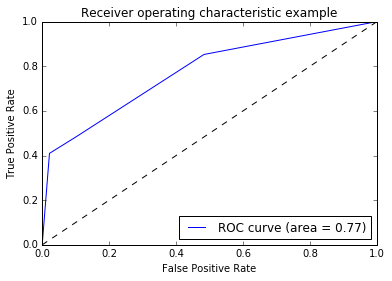

In [29]:
#ROC
probas = clf1.predict_proba(a_test)
# probas est une matrice de deux colonnes avec la proabilités d'appartenance à chaque classe
fpr, tpr, thresholds = roc_curve(b_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

max_depth 1 erreur 0.205727706278 0.203926229011
max_depth 2 erreur 0.205727706278 0.203926229011
max_depth 3 erreur 0.192019891551 0.190945940852
max_depth 4 erreur 0.186186145084 0.187014363692
max_depth 5 erreur 0.185701247368 0.186379926089
max_depth 6 erreur 0.180457744088 0.1848716915
max_depth 7 erreur 0.17656561409 0.188676746284
max_depth 8 erreur 0.17119724782 0.18884788169
max_depth 9 erreur 0.16568701438 0.190607283877


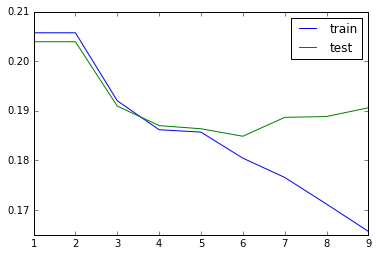

In [30]:
#Sur toutes les variables 
a_train, a_test, b_train, b_test = train_test_split(df_nonNormalized, y, test_size=0.33)
curves = []
for max_depth in range(1,10) :
    clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=max_depth)
    clf = clf.fit(a_train, b_train)
    erra = mean_squared_error( clf.predict(a_train), b_train)**0.5
    errb = mean_squared_error( clf.predict(a_test), b_test)**0.5
    print("max_depth",max_depth, "erreur",erra,errb)
    curves.append((max_depth, erra,errb, clf) )
plt.plot ( [c[0] for c in curves], [c[1] for c in curves], label="train")
plt.plot ( [c[0] for c in curves], [c[2] for c in curves], label="test")
plt.legend()

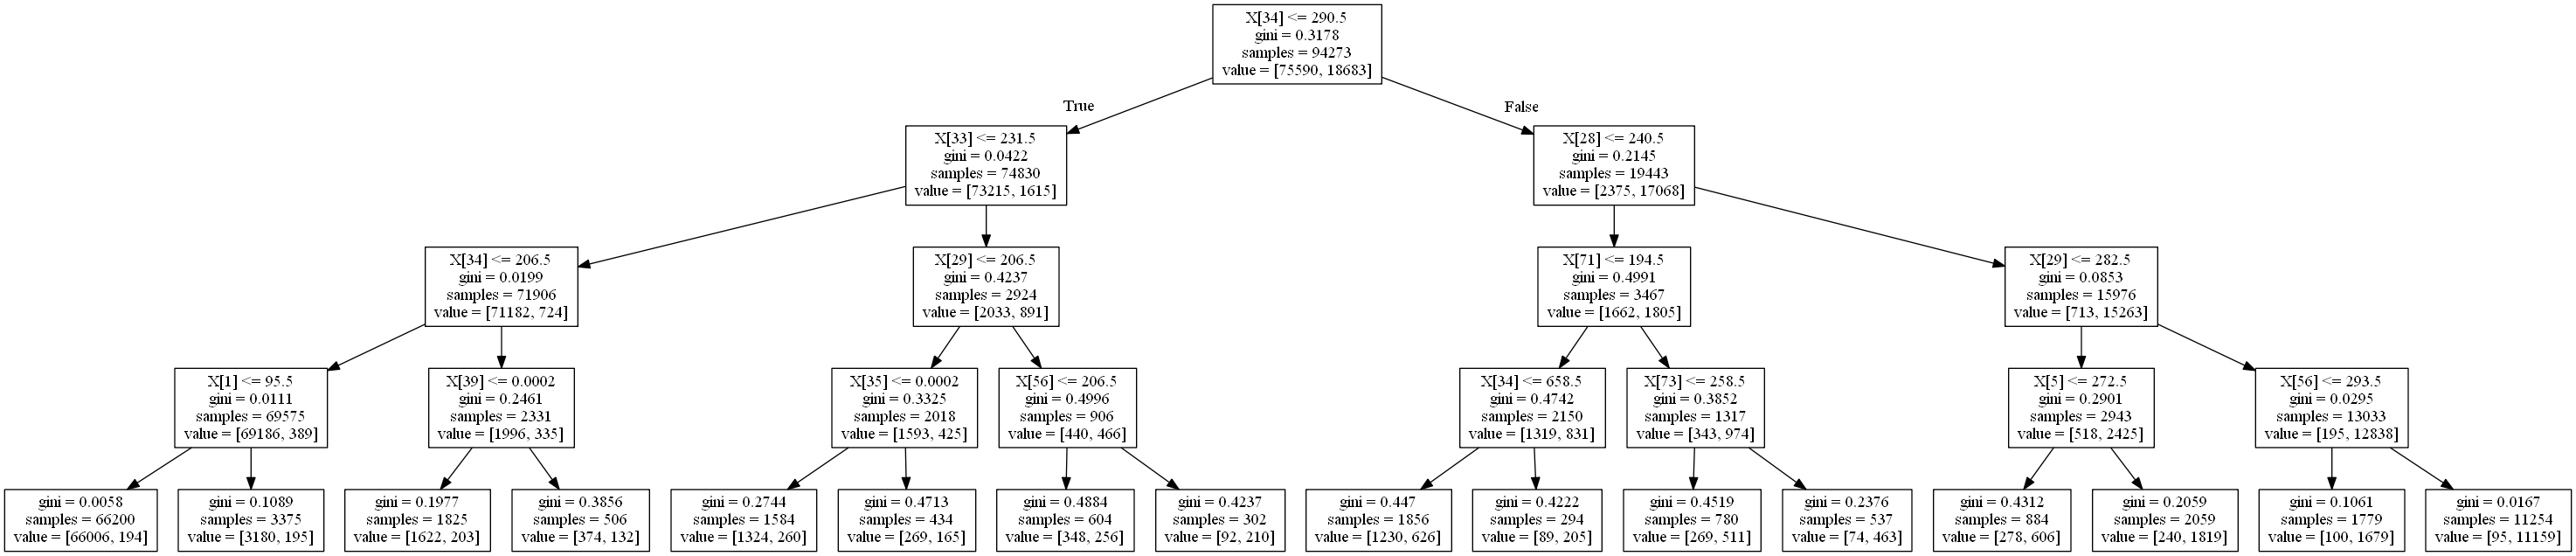

In [31]:
clf2 = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
clf2 = clf2.fit(a_train, b_train)

export_graphviz(clf2, out_file="arbre2.dot")
# on remplace X[i] par les noms des variables
with open("arbre2.dot","r") as f: text = f.read()

with open("arbre2.dot","w") as f: f.write(text)
cwd = os.getcwd()
os.system ("\"D:\\PyEnsae\\tools\\Graphviz\\bin\\dot.exe\" -Tpng {0}\\arbre2.dot -o {0}\\arbre2.png".format(cwd))
Image("arbre2.png")

In [32]:
predicted = clf2.predict(a_test)
expected = b_test
cm(expected,predicted)

array([[36710,   632],
       [  992,  8100]])

Area under the ROC curve : 0.988231


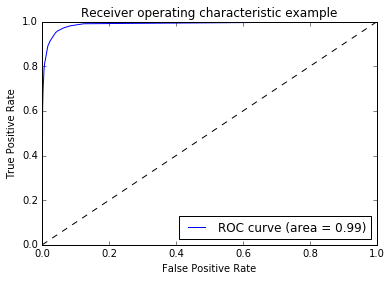

In [33]:

probas = clf2.predict_proba(a_test)
# probas est une matrice de deux colonnes avec la proabilités d'appartenance à chaque classe
fpr, tpr, thresholds = roc_curve(b_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

Méthode 3 : SVM (Support Vector Machine)
-------------------------------------------------

Nous utilisons ici un modèle SVM linéaire pour des raisons computationnelles.
Le temps de calcul d'un modèle SVM polynomial , de degré 3 par exemple, prend énormément de temps à "fitter" pour notre jeu de données.

In [23]:
#Choosing data
#a_train, a_test, b_train, b_test = train_test_split(accroissements, y, test_size=0.33)
a_train, a_test, b_train, b_test = train_test_split(df_nonNormalized, y, test_size=0.33)

In [24]:
#Basic SVM
clf =  SGDClassifier(loss="hinge",alpha=0.01, n_iter=200, fit_intercept=True)
clf.fit(a_train, b_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=200, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [25]:
#Confusion matrix
y_predicted = clf.predict(a_test)
cm(b_test,y_predicted)


array([[36640,   651],
       [  977,  8166]])

Area under the ROC curve : 0.937842


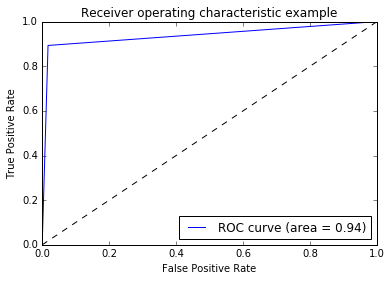

In [26]:
#Roc Curve
fpr, tpr, thresholds = roc_curve(b_test, y_predicted)
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

***Using 5 fold cross validation for SVM***

In [2]:
def weights(y):
    zeroPercentage = sum(y==0)/sum(y==1)
    weights = np.ones(y.size)
    weights[weights==1]= zeroPercentage
    return weights

def linearSVM(data,y):
    linear_svc = SGDClassifier(loss="hinge", alpha=0.01, class_weight ='balanced',n_iter=200, fit_intercept=True)
    #linear_svc = svm.LinearSVC(C=1,random_state=1234)
    y_predicted = cross_val_predict(linear_svc, data,y, cv=5)
    scores = hinge_loss(y,y_predicted)
    scoreszero=  1 - zero_one_loss(y,y_predicted,normalize=True)
    print(scores.mean())
    print(scoreszero.mean())
    print(cm(y,y_predicted))

In [28]:
y_svm = copy.deepcopy(y)
y_svm[y_svm==0] = -1
np.unique(y_svm)

In [30]:
linearSVM(accroissements,y)

1.41663172408
0.385972268615
[[28189 84743]
 [ 1655 26120]]


In [31]:
linearSVM(accroissements.iloc[:,indices_contributions_variables], y)

1.41376050943
0.388843483267
[[28810 84122]
 [ 1872 25903]]


In [32]:
linearSVM(accroissements.iloc[:,np.divide(indices_variables_auteurs,7)],y)

1.44031924496
0.362284747738
[[25120 87812]
 [ 1919 25856]]


In [33]:
linearSVM(X_unif,y_unif)

0.546678667867
0.953321332133
[[26728  1047]
 [ 1546 26229]]


In [3]:
linearSVM(df_nonNormalized,y)

NameError: name 'df_nonNormalized' is not defined

# Conclusion

L'étude conduite montre que les méthodes de classifications classiques ont des performances relativement bonnes dans à peu près toutes les configurations. Que ce soit en prenant en compte les variables d'accroissement ou simplement en prenant le tableau de données sans filtrage en particulier.
Même si nous avons omis la notion de temps, les performances sont supérieurs à 85%, 90% dans certains cas. Comme cité en introduction, il faut remettre en perspective ces résutlats car la proportion entre Buzz/Non Buzz dans les données d'origine est déséquilibrée. Il serait intéressant de runner nos simulations sur un quantité de données plus large en faisant attention à la distribution des résultats Buzz/Non Buzz. 

# Perspective

Le résultat est plus très intéressant du point de vue de la classification car nous n'avons pas réellement pris en compte l'évolution des variables dans le temps. L'artéfact créé en utilisant les taux d'accroissement, même s'il donne des résultats corrects, ne prend pas vraiment en compte la notion d'autocorrélation entre les variables, ni la notion de temps, propre à la notion de Buzz.
L'extention est de mettre en place un modèle d'apprentissage sur séries temporelles multivariés (Modèle autorégressif vectoriel - VAR par exemple) et prendre en compte les deux notions citées ci-dessus et d'en comparer les résultats avec les méthodes que nous avons mis en place.
Le but est de savoir si 1- les performances sont meilleures , 2 - Identifier les variables clé sur lesquelles nous povons nous concentrés pour la prédiction. Cela optimiserai gradement nos résultats et la rapidité des simulations.


